In [10]:
import sys
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\asus\OneDrive\EV-projects\evcs-projects")
SCRIPTS_DIR = PROJECT_ROOT / "scripts"

sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(SCRIPTS_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SCRIPTS_DIR :", SCRIPTS_DIR)

import destruction_reconstruction
print("Imported from:", destruction_reconstruction.__file__)


PROJECT_ROOT: C:\Users\asus\OneDrive\EV-projects\evcs-projects
SCRIPTS_DIR : C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts
Imported from: C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts\destruction_reconstruction.py


PROJECT_ROOT: C:\Users\asus\OneDrive\EV-projects\evcs-projects
SCRIPTS_DIR : C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts
Imported destruction_reconstruction from: C:\Users\asus\OneDrive\EV-projects\evcs-projects\scripts\destruction_reconstruction.py
Loaded instance: C:\Users\asus\OneDrive\EV-projects\evcs-projects\data\instances\inst_N150_seed1.json
Defaults: P= 10 Q= 45.0 D= 2.8
load_solution=False and check results.termination_condition and
results.found_feasible_solution() before loading a solution.
out keys: ['policy', 'score_exact', 'time_exact', 'optimal_exact', 'score_greedy', 'score_LS', 'time_LS', 'score_DR', 'DR_log', 'compare_exact_vs_best', 'm_exact', 'm_best']
score_exact: 415.8621272580096
score_LS   : 414.1016450963619
score_DR   : 437.2670673596802
Saved DR log: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\DR_log_N150_seed1_closest_only.csv


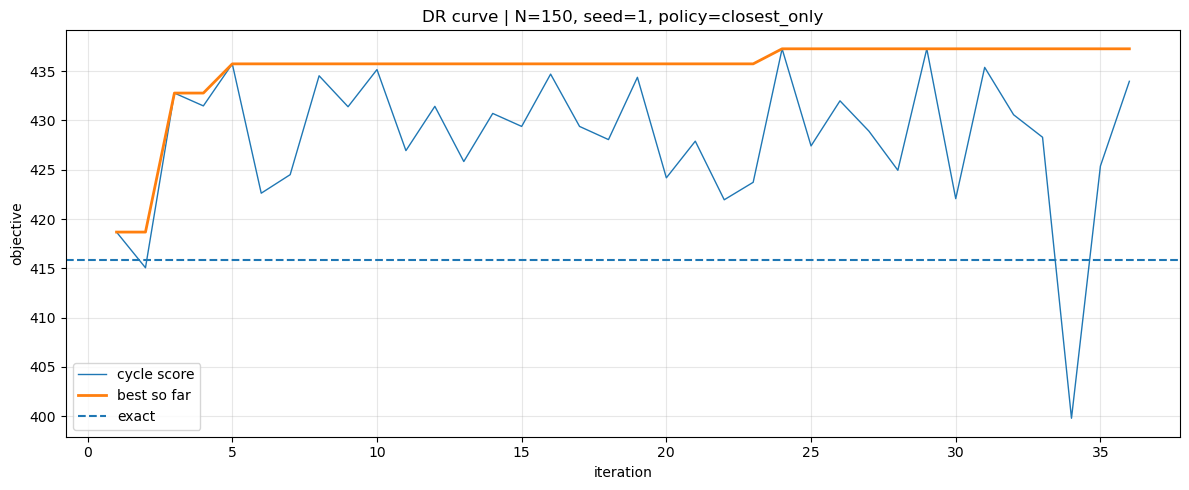

Saved DR curve: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\DR_curve_N150_seed1_closest_only.png
compare_exact_vs_best: {'n_open_A': 10, 'n_open_B': 10, 'only_A': [18, 32, 49, 51, 52, 65, 68, 114, 131], 'only_B': [9, 76, 96, 98, 104, 121, 135, 136, 148], 'common': [112]}
Saved compare dict: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\compare_exact_vs_best_N150_seed1_closest_only.csv
Exact exists: True
Best exists : True


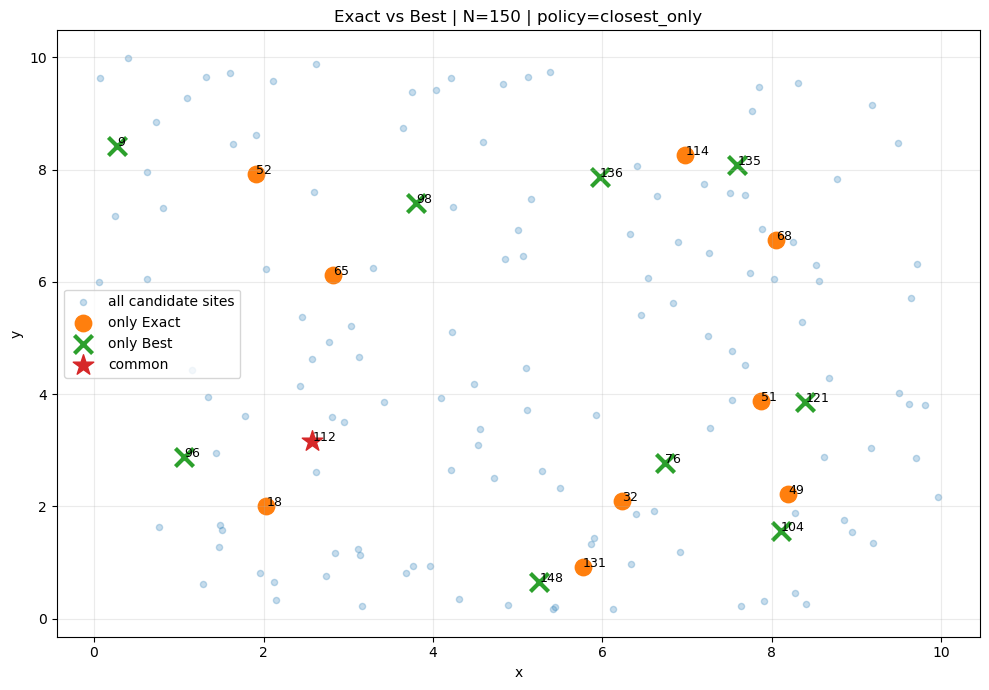

,station,status,load_exact,load_best,load_diff_best_minus_exact
0,112,common,43.200339,44.772694,1.572355
1,114,only_exact,45.000000,0.000000,-45.000000
2,49,only_exact,45.000000,0.000000,-45.000000
3,68,only_exact,45.000000,0.000000,-45.000000
4,52,only_exact,45.000000,0.000000,-45.000000
5,65,only_exact,43.880344,0.000000,-43.880344
6,18,only_exact,42.751087,0.000000,-42.751087
7,131,only_exact,41.579948,0.000000,-41.579948
8,51,only_exact,35.837514,0.000000,-35.837514
9,32,only_exact,28.612896,0.000000,-28.612896


Saved load comparison table: C:\Users\asus\OneDrive\EV-projects\evcs-projects\results\load_compare_N150_seed1_closest_only.csv


In [15]:
# ============================================================
# 0) PATH FIX (FIRST CELL) - makes imports work
# ============================================================
import sys
from pathlib import Path

PROJECT_ROOT = Path(r"C:\Users\asus\OneDrive\EV-projects\evcs-projects")
SCRIPTS_DIR  = PROJECT_ROOT / "scripts"

sys.path.insert(0, str(PROJECT_ROOT))
sys.path.insert(0, str(SCRIPTS_DIR))

print("PROJECT_ROOT:", PROJECT_ROOT)
print("SCRIPTS_DIR :", SCRIPTS_DIR)

import destruction_reconstruction
print("Imported destruction_reconstruction from:", destruction_reconstruction.__file__)


# ============================================================
# 1) IMPORTS
# ============================================================
import os, json, time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from destruction_reconstruction import (
    run_one_policy,
    run_batch_one_pass,
    default_parameters_for
)

from scripts.randomInstance import generate_instance, save_instance, load_instance


# ============================================================
# 2) HELPERS (PLOTS + LOAD TABLE) - NO algorithm duplication
# ============================================================
def _get_val(v):
    try:
        return float(v.value) if getattr(v, "value", None) is not None else 0.0
    except Exception:
        try:
            return float(v)
        except Exception:
            return 0.0

def open_sites(m, thr=0.5):
    return [j for j in m.x if _get_val(m.x[j]) > thr]

def station_loads(m, demand_I, thr_open=0.5):
    """
    load[j] = sum_i demand[i] * y[i,j]  (for open stations only)
    """
    opens = set(open_sites(m, thr=thr_open))
    load = {j: 0.0 for j in opens}

    # m.Arcs is (i,j) for feasible arcs
    for (i, j) in m.Arcs:
        if j in load:
            load[j] += float(demand_I[i]) * _get_val(m.y[i, j])
    return load

def compare_load_table(m_exact, m_best, demand_I):
    """
    DataFrame on union of open stations:
      station | load_exact | load_best | status | diff
    """
    load_e = station_loads(m_exact, demand_I) if m_exact is not None else {}
    load_b = station_loads(m_best,  demand_I) if m_best  is not None else {}

    opens_e = set(load_e.keys())
    opens_b = set(load_b.keys())
    union = sorted(opens_e | opens_b)

    rows = []
    for j in union:
        status = "common" if (j in opens_e and j in opens_b) else ("only_exact" if j in opens_e else "only_best")
        rows.append({
            "station": j,
            "status": status,
            "load_exact": load_e.get(j, 0.0),
            "load_best":  load_b.get(j, 0.0),
        })

    df = pd.DataFrame(rows)
    df["load_diff_best_minus_exact"] = df["load_best"] - df["load_exact"]

    # Sort: common first, then only_exact, then only_best (or change if you prefer)
    order = {"common": 0, "only_exact": 1, "only_best": 2}
    df["_ord"] = df["status"].map(order)
    df = df.sort_values(by=["_ord", "load_exact", "load_best"], ascending=[True, False, False]).drop(columns=["_ord"])
    df = df.reset_index(drop=True)
    return df

def plot_open_sets(coords_J, open_exact, open_best, title="Exact vs Best open sites", annotate=True):
    """
    coords_J: list/array of (x,y) for candidate sites J (index=station id)
    open_exact/open_best: list of station indices
    """
    coords_J = np.asarray(coords_J)
    x_all, y_all = coords_J[:, 0], coords_J[:, 1]

    set_e = set(open_exact) if open_exact is not None else set()
    set_b = set(open_best)  if open_best  is not None else set()
    common = sorted(set_e & set_b)
    only_e = sorted(set_e - set_b)
    only_b = sorted(set_b - set_e)

    plt.figure(figsize=(10, 7))
    plt.scatter(x_all, y_all, s=20, alpha=0.25, label="all candidate sites")

    if only_e:
        plt.scatter(coords_J[only_e, 0], coords_J[only_e, 1], s=140, marker="o", label="only Exact")
    if only_b:
        plt.scatter(coords_J[only_b, 0], coords_J[only_b, 1], s=170, marker="x", linewidths=3, label="only Best")
    if common:
        plt.scatter(coords_J[common, 0], coords_J[common, 1], s=240, marker="*", label="common")

    if annotate:
        for j in sorted(set_e | set_b):
            plt.text(coords_J[j, 0], coords_J[j, 1], f"{j}", fontsize=9)

    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.grid(True, alpha=0.25)
    plt.tight_layout()
    plt.show()


# ============================================================
# 3) LOAD / GENERATE INSTANCE
# ============================================================
N = 150
seed = 1

inst_dir = str(PROJECT_ROOT / "data" / "instances")
os.makedirs(inst_dir, exist_ok=True)

inst_path = os.path.join(inst_dir, f"inst_N{N}_seed{seed}.json")

if os.path.exists(inst_path):
    inst = load_instance(inst_path)
    print("Loaded instance:", inst_path)
else:
    inst = generate_instance(N=N, seed=seed)
    save_instance(inst, inst_path)
    print("Generated+saved instance:", inst_path)

P, Q, D = default_parameters_for(N)
print("Defaults:", "P=", P, "Q=", Q, "D=", D)

policy = "closest_only"


# ============================================================
# 4) RUN ONE POLICY (Pipeline only; no duplication)
# ============================================================
out = run_one_policy(
    inst=inst,
    policy=policy,
    P=P, Q=Q, D=D,
    forbid_self=False,
    max_iter=15,
    dr_time_limit=4000,
    dr_log_every=1,
    greedy_mode="W1",       # "deterministic" / "W1" / "W2"
    destroy_mode="area",    # "random"/"area"/"cluster"/"demand_low"/"demand_high"
    exact_time_limit=60,
    exact_mip_gap=0.05,
    allow_multi_charger=False,
    seed=seed
)

print("out keys:", list(out.keys()))
print("score_exact:", out.get("score_exact"))
print("score_LS   :", out.get("score_LS"))
print("score_DR   :", out.get("score_DR"))


# ============================================================
# 5) SAVE DR LOG + DR CURVE
# ============================================================
results_dir = str(PROJECT_ROOT / "results")
os.makedirs(results_dir, exist_ok=True)

dr_df = out["DR_log"]
dr_csv = os.path.join(results_dir, f"DR_log_N{N}_seed{seed}_{policy}.csv")
dr_df.to_csv(dr_csv, index=False)
print("Saved DR log:", dr_csv)

plt.figure(figsize=(12, 5))
plt.plot(dr_df["iteration"], dr_df["score"], label="cycle score", linewidth=1)
plt.plot(dr_df["iteration"], dr_df["best"],  label="best so far", linewidth=2)

score_exact = out.get("score_exact", np.nan)
if score_exact is not None and not np.isnan(score_exact):
    plt.axhline(score_exact, linestyle="--", label="exact")

plt.title(f"DR curve | N={N}, seed={seed}, policy={policy}")
plt.xlabel("iteration")
plt.ylabel("objective")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()

dr_png = os.path.join(results_dir, f"DR_curve_N{N}_seed{seed}_{policy}.png")
plt.savefig(dr_png, dpi=180)
plt.show()
print("Saved DR curve:", dr_png)


# ============================================================
# 6) SAVE SIMPLE OPEN-SET COMPARISON DICT (already in out)
# ============================================================
cmp = out.get("compare_exact_vs_best", None)
print("compare_exact_vs_best:", cmp)

if cmp:
    cmp_csv = os.path.join(results_dir, f"compare_exact_vs_best_N{N}_seed{seed}_{policy}.csv")
    pd.DataFrame({"metric": list(cmp.keys()), "value": [str(v) for v in cmp.values()]}).to_csv(cmp_csv, index=False)
    print("Saved compare dict:", cmp_csv)


# ============================================================
# 7) MAP PLOT + LOAD COMPARISON TABLE (needs models)
# ============================================================
coords_J = inst["coords_J"]
demand_I = inst["demand_I"]

m_exact = out.get("m_exact", None)
m_best  = out.get("m_best", None)

print("Exact exists:", m_exact is not None)
print("Best exists :", m_best  is not None)

if (m_exact is None) or (m_best is None):
    print("\n⚠️ Your run_one_policy() is not returning m_exact/m_best.")
    print("To enable the map+load table, edit destruction_reconstruction.py and add at the end of run_one_policy():")
    print("   return {..., 'm_exact': m_exact, 'm_best': m_best}")
else:
    open_e = open_sites(m_exact)
    open_b = open_sites(m_best)

    plot_open_sets(
        coords_J,
        open_exact=open_e,
        open_best=open_b,
        title=f"Exact vs Best | N={len(coords_J)} | policy={out['policy']}",
        annotate=True
    )

    df_load = compare_load_table(m_exact, m_best, demand_I)
    display(df_load)

    load_csv = os.path.join(results_dir, f"load_compare_N{N}_seed{seed}_{policy}.csv")
    df_load.to_csv(load_csv, index=False)
    print("Saved load comparison table:", load_csv)



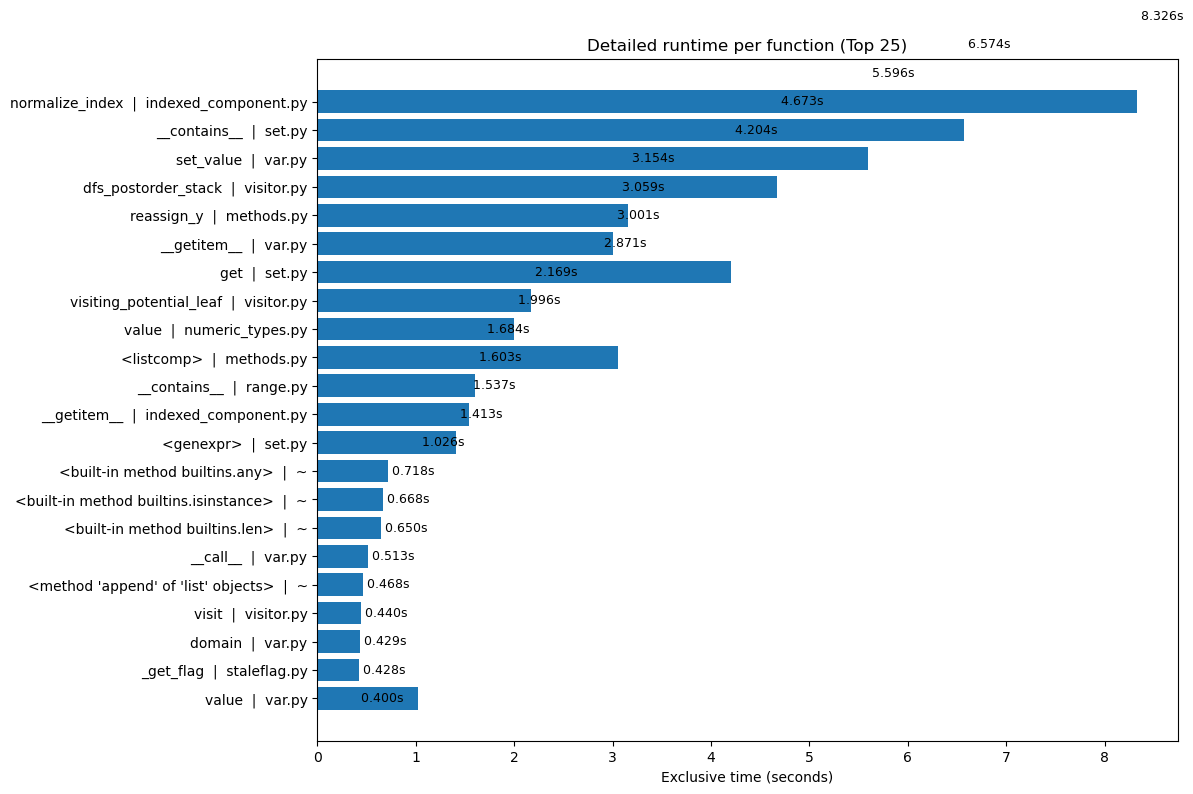

,function,file,lineno,ncalls,tottime_s,cumtime_s,tottime_%
0,normalize_index,indexed_component.py,44,12483268,8.325876,8.967594,13.518690
1,__contains__,set.py,536,16511859,6.573519,27.063365,10.673395
2,set_value,var.py,134,4029167,5.595628,15.592604,9.085597
3,dfs_postorder_stack,visitor.py,887,16047,4.672992,10.991950,7.587517
4,get,set.py,1325,12483044,4.204043,13.171465,6.826087
5,reassign_y,methods.py,359,31126,3.153762,48.675793,5.120750
6,<listcomp>,methods.py,365,622520,3.058715,21.850730,4.966423
7,__getitem__,var.py,965,8161147,3.001014,4.537361,4.872734
8,get,set.py,2738,4029079,2.871063,6.650438,4.661733
9,visiting_potential_leaf,visitor.py,1202,5311497,2.168689,4.657390,3.521291


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# ------------------------------------------------------------
# Load full profiling table
# ------------------------------------------------------------
profile_csv = os.path.join(results_dir, "profile_full_N20_seed1_closest_only.csv")
df = pd.read_csv(profile_csv)

# ------------------------------------------------------------
# Choose what to visualize
#   - Use tottime_s for "where CPU is actually spent"
#   - Or use cumtime_s for call-stack impact
# ------------------------------------------------------------
TIME_COL = "tottime_s"   # change to "cumtime_s" if you want inclusive time
TOP_K = 25               # number of functions to show

df_plot = (
    df.sort_values(TIME_COL, ascending=False)
      .head(TOP_K)
      .copy()
)

# Build readable labels
df_plot["label"] = (
    df_plot["function"].astype(str)
    + "  |  "
    + df_plot["file"].astype(str)
)

# Reverse for nice top-down plotting
df_plot = df_plot.iloc[::-1]

# ------------------------------------------------------------
# Horizontal bar chart
# ------------------------------------------------------------
plt.figure(figsize=(12, 8))
plt.barh(df_plot["label"], df_plot[TIME_COL])
plt.xlabel("Exclusive time (seconds)" if TIME_COL == "tottime_s" else "Cumulative time (seconds)")
plt.title(f"Detailed runtime per function (Top {TOP_K})")

# Annotate bars with time
for i, v in enumerate(df_plot[TIME_COL]):
    plt.text(v, i, f" {v:.3f}s", va="center", fontsize=9)

plt.tight_layout()
plt.show()

# ------------------------------------------------------------
# Clean table for inspection / presentation
# ------------------------------------------------------------
display_cols = [
    "function",
    "file",
    "lineno",
    "ncalls",
    "tottime_s",
    "cumtime_s",
    "tottime_%",
]

display(
    df_plot[display_cols]
    .sort_values("tottime_s", ascending=False)
    .reset_index(drop=True)
)
